# FastAI XLA Extensions Library

> The FastAI XLA Extensions library package allows your fastai/Pytorch models to run on TPUs using the Pytorch-XLA library.

## Install

`pip install git+https://github.com/butchland/fastai_xla_extensions`

## How to use

### Configure the Pytorch XLA package 

The Pytorch xla package requires an environment supporting TPUs (Kaggle kernels, GCP or Colab environments required)

If running on Colab, make sure the Runtime Type is set to TPU.


In [ ]:
#hide
#colab
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#hide
#colab
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
#hide
#colab
!curl -s https://course19.fast.ai/setup/colab | bash 

Install fastai and the fastai_xla_extensions packages

In [ ]:
#hide_output
#colab
!pip install -Uqq fastai  --upgrade

```
!pip install git+https://github.com/butchland/fastai_xla_extensions
```

Install Pytorch-XLA

In [ ]:
#hide_output
#colab
VERSION = "20200707"  #@param ["1.5" , "20200325","20200707", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

In [ ]:
#hide
!pip freeze | grep torch
!pip freeze | grep fastai

torch==1.7.0a0+12b5bdc
torch-xla==1.6+5430aca
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.0a0+86b6c3e
fastai==0.0.23


In [ ]:
#hide
#colab
%cd /content/drive/My\ Drive/fastai_xla_extensions/
import fastai_xla_extensions.core
%cd /content

In [ ]:
#hide
#local
%cd ..
import fastai_xla_extensions.core
%cd nbs

### Import the libraries
Import the fastai and fastai_xla_extensions libraries

In [ ]:
#colab
#hide_output
import fastai_xla_extensions.core

**IMPORTANT: Make sure to import fastai_xla_extensions.core BEFORE importing fastai libraries** 

If you don't, fastai will not default to use tpu device but will instead use the cpu.

In [ ]:
from fastai.vision.all import *

### Example
Build a MNIST classifier -- adapted from fastai course [Lesson 4 notebook](https://github.com/fastai/course-v4/blob/master/nbs/04_mnist_basics.ipynb)

In [ ]:
#hide
#colab
%cd /content

Load MNIST dataset 

In [ ]:
path = untar_data(URLs.MNIST_TINY)

In [ ]:
#hide
Path.BASE_PATH = path

Create Fastai DataBlock


_Note that batch transforms are currently
set to none as they seem to slow the training
on the TPU (for investigation)._

In [ ]:
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(),
    get_y=parent_label,
    item_tfms=Resize(28),
    batch_tfms=[]
)

In [ ]:
#colab
datablock.summary(path)

Setting-up type transforms pipelines
Found 1428 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_tiny/train/7/703.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': (#2) ['3','7'], 'add_na': False}
    starting from
      /root/.fastai/data/mnist_tiny/train/7/703.png
    applying parent_label gives
      7
    applying Categorize -- {'vocab': (#2) ['3','7'], 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(1))


Setting up after_item: Pipeline: Resize -- {'size': (28, 28), 'method': 'crop', 'pad_mode': 'reflection'} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}

Building o

Create the dataloader

In [ ]:
dls = datablock.dataloaders(path)

In [ ]:
#colab
dls.device

device(type='xla', index=1)

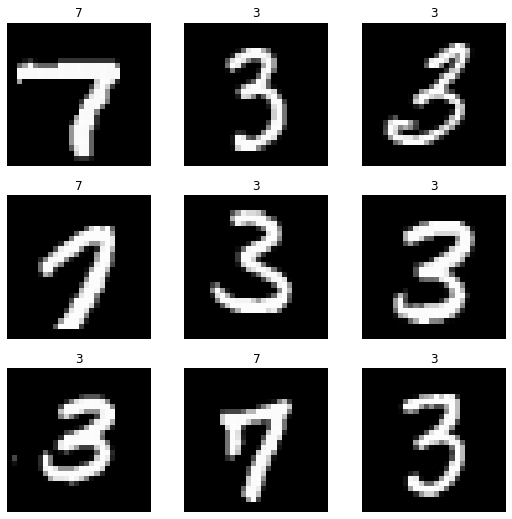

In [ ]:
#colab
dls.show_batch()

Create a Fastai CNN Learner

In [ ]:
#colab
learner = cnn_learner(dls, resnet18, metrics=accuracy)
                      

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
#colab
learner.summary()

Sequential (Input shape: ['64 x 3 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 14 x 14    9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 14 x 14    128        True      
________________________________________________________________
ReLU                 64 x 64 x 14 x 14    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 7 x 7      0          False     
________________________________________________________________
Conv2d               64 x 64 x 7 x 7      36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 7 x 7      128        True      
________________________________________________________________
ReLU                 64 x 64 x 7 x 7      0          False     
___________________________________________________

Using the `lr_find` works 

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=1.9054607491852948e-06)

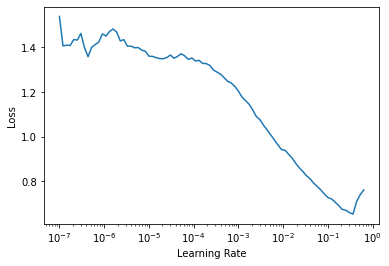

In [ ]:
#colab
learner.lr_find()

Fine tune model


In [ ]:
#colab
learner.fine_tune(1, base_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.745400,0.949072,0.706724,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.330027,0.192076,0.932761,00:09


Unfreeze the model

In [ ]:
#colab
learner.unfreeze()

Run the LR Finder again. 

SuggestedLRs(lr_min=0.00020892962347716094, lr_steep=9.12010818865383e-07)

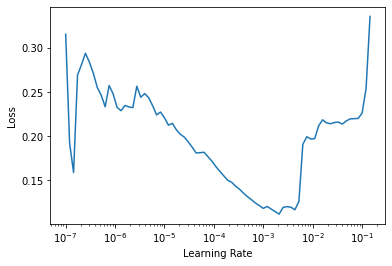

In [ ]:
#colab
learner.lr_find()

Further fine-tuning

In [ ]:
#colab
learner.fit_one_cycle(1,slice(7e-4),pct_start=0.99)

epoch,train_loss,valid_loss,accuracy,time
0,0.155878,0.152143,0.959943,00:11


In [ ]:
#hide
#colab
learner.save('stage-1')

In [ ]:
#hide
#colab
learner.load('stage-1')

Model params are using TPU

In [ ]:
#colab
list(learner.model.parameters())[0].device

device(type='xla', index=1)

In [ ]:
#colab
learner.unfreeze()

In [ ]:
#colab
learner.fit_one_cycle(4,lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.097287,0.154531,0.955651,00:06
1,0.074006,0.140767,0.965665,00:02
2,0.064490,0.134700,0.971388,00:02
3,0.055005,0.129603,0.971388,00:02


In [ ]:
#colab
learner.fit_one_cycle(4,lr_max=slice(4e-6,5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.031957,0.118141,0.974249,00:02
1,0.022216,0.110391,0.972818,00:02
2,0.023388,0.116325,0.971388,00:02
3,0.019499,0.114521,0.975680,00:02


Plot loss seems to be working fine.

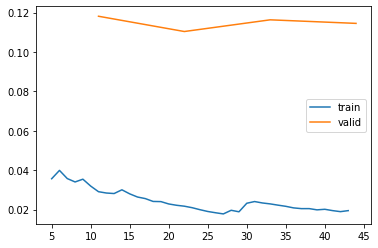

In [ ]:
#colab
learner.recorder.plot_loss()

## Samples

Other examples of fastai notebooks using the fastai_xla_extensions package are also available here: 

* [Vision](https://github.com/butchland/fastai_xla_extensions/blob/master/samples/MNIST_TPU_demo.ipynb) [![](https://camo.githubusercontent.com/52feade06f2fecbf006889a904d221e6a730c194/68747470733a2f2f636f6c61622e72657365617263682e676f6f676c652e636f6d2f6173736574732f636f6c61622d62616467652e737667)](https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/samples/MNIST_TPU_demo.ipynb)

* [Collaborative Filtering](https://github.com/butchland/fastai_xla_extensions/blob/master/samples/MovieLensCollaborativeFilteringTPU.ipynb) [![](https://camo.githubusercontent.com/52feade06f2fecbf006889a904d221e6a730c194/68747470733a2f2f636f6c61622e72657365617263682e676f6f676c652e636f6d2f6173736574732f636f6c61622d62616467652e737667)](https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/samples/MovieLensCollaborativeFilteringTPU.ipynb)

* [Tabular](https://github.com/butchland/fastai_xla_extensions/blob/master/samples/TabularTrainingTPUdemo.ipynb) [![](https://camo.githubusercontent.com/52feade06f2fecbf006889a904d221e6a730c194/68747470733a2f2f636f6c61622e72657365617263682e676f6f676c652e636f6d2f6173736574732f636f6c61622d62616467652e737667)](https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/samples/TabularTrainingTPUdemo.ipynb)

More samples will be added in the future as we fix issues and implement more capabilities.


## Status
The fastai XLA extensions library is still in very early development phase (not even alpha) which means there's still a lot of things not working. 

Use it at your own risk.

If you wish to contribute to the project, fork it and make pull request. 

This project uses [nbdev](https://nbdev.fast.ai/) -- a jupyter notebook first development environment and is being developed on [Colab](https://colab.research.google.com).
